### Libraries used

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# White Vote Project

## Objective
The objective of this project is to explore the possibility of predicting the outcome of the 2022 Elections in Colombia by analyzing the available data on voting patterns. (Specially white votes)

## Procedure 
The procedure involved mining data from government repositories, with a focus on selecting data that has been shown in previous research to be important factors affecting voting patterns. We then analyzed this data to determine if there are any significant relationships between the variables. To do this, we utilized a machine learning regressor to identify any potential correlations.


### Data
The data used are the votes from previous elections [2014, 2018, 2020], which serve as our Y training data for our model. For the attributes, we use the following:

- The statistics of education in each department of Colombia
- The statistics of internet access in each department
- The statistics of poverty in each department.


In [12]:
#Datos
data_2014=pd.read_csv("Data/Camara 2014.csv", delimiter=";",encoding="ISO-8859-1")
data_2018=pd.read_csv("Data/Camara 2018.csv", delimiter=";")
data_2020=pd.read_csv("Data/Camara 2022.csv", delimiter=";",encoding="ISO-8859-1")

#Variable 1
Estad_educacion=pd.read_csv("Data/MEN_ESTADISTICAS_EN_EDUCACION_EN_PREESCOLAR__B_SICA_Y_MEDIA_POR_DEPARTAMENTO.csv", delimiter=",",decimal=".")

#Variable 2
Estad_internet=pd.read_csv("Data/Internet_Fijo_Penetraci_n_Departamentos.csv", delimiter=";",decimal=",")

#Variable 3
Estad_pobreza=pd.read_csv("Data/Ind_Pob_Mult.csv", delimiter=";",decimal=".",encoding="ISO-8859-1")

### Data Cleaning
Each data file comes in different formats, so we first perform data cleaning before continuing with the project.


In [13]:
#Data's keys
llav_data_2014=data_2014.keys()
llav_data_2018=data_2018.keys()
llav_data_2020=data_2020.keys()
llav_Estad_educacion=Estad_educacion.keys()
llav_Estad_internet=Estad_internet.keys()
llav_Estad_pobreza=Estad_pobreza.keys()

ii_estad_2020=Estad_educacion[llav_Estad_educacion[0]]==2020
Estad_educacion_2020=Estad_educacion[ii_estad_2020].sort_values(by=llav_Estad_educacion[2])

#Correction to years
ii_estad_2018=Estad_educacion[llav_Estad_educacion[0]]==2018
Estad_educacion=Estad_educacion[ii_estad_2018].sort_values(by=llav_Estad_educacion[2])

#Ordering data in a similar way to other data
data_2018=data_2018.sort_values(by=llav_data_2018[0])
data_2014=data_2014.sort_values(by=llav_data_2014[0])
data_2020=data_2020.sort_values(by=llav_data_2020[0])
Estad_internet=Estad_internet.sort_values(by=llav_Estad_internet[1])
Estad_pobreza=Estad_pobreza.sort_values(by=llav_Estad_pobreza[0])

zs=np.array(Estad_pobreza[llav_Estad_pobreza[2]])
ys=np.array(Estad_educacion[llav_Estad_educacion[9]]/100)
xs=np.array(Estad_internet[llav_Estad_internet[2]])

#The blank votes are in thousands, so we are standardizing the data.
col=np.array((data_2018[llav_data_2018[2]]/data_2018[llav_data_2018[1]]))



### Model 
Since the model is very simple, we programmed a basic ML model that works with gradient descent to minimize the mean difference between predicted and actual data. 

Using three attributes, we aim to determine three $beta$ variables (the slope) for each attribute. 

This model works with Monte Carlo simulations, allowing us to obtain an error and mean value for each slope. By using error propagation, we can find the error of the predicted data.

In [14]:
n_iteraciones = 10000
betas = np.zeros([n_iteraciones,5])
#creates a montecarlo environment, increasing data
def shuffle(lista_a,lista_b,nombre):
    diferencia=np.mean(lista_a)-np.mean(lista_b)
    N_interracciones=10000
    lista_grande=list(lista_a)+list(lista_b)
    diferencias=np.zeros(N_interracciones)
    for i in range(N_interracciones):
        np.random.shuffle(lista_grande)
        lista_a1=lista_grande[:len(lista_a)]
        lista_b1=lista_grande[len(lista_a):]
        diferencias[i]=np.mean(lista_a1)-np.mean(lista_b1)
    p_value=2*(np.count_nonzero(diferencias>diferencia)/len(diferencias))
    plt.figure()
    plt.title("{} y P_value de {}".format(nombre,p_value))
    plt.hist(diferencias, bins=40, density="true")
    plt.vlines(diferencia,0,4,color="red")

#Our lineal model
def model(x, betas):
    y = betas[0]
    for i in range(1,len(betas)):
        y += betas[i]*x[i-1]
    return y

#Looks for the fastest way to encounter the convergence of our model.
def loglike(x_obs, y_obs, sigma_y_obs, betas):
    n_obs = len(y_obs)
    l = 0.0
    for i in range(n_obs):
        l += -0.5 * (y_obs[i] - model(x_obs[i,:], betas))**2/sigma_y_obs[i]**2
    return l

xobser=np.empty((33,3))
x_obs=xobser
for j in range(3):
    for i in range(len(xobser)):
        if j==0:
            xobser[i,j]=xs[i]
        if j==1:    
             xobser[i,j]=ys[i]
        if j==2:
             xobser[i,j]=zs[i]

y_obs=col
sigma_y_obs = np.ones(len(y_obs))*0.01

n_iteraciones = 10000
betas = np.zeros([n_iteraciones,4])
for i in range(1,n_iteraciones):
    betas_now = betas[i-1,:]
    betas_next = betas_now + np.random.normal(scale=0.01, size=4)
    
    loglike_now = loglike(x_obs, y_obs, sigma_y_obs, betas_now)
    loglike_next = loglike(x_obs, y_obs, sigma_y_obs, betas_next)
    
    gamma = np.min([np.exp(loglike_next-loglike_now),1.0])
    alpha = np.random.random()
    
    if alpha < gamma:
        betas[i,:] = betas_next
    else:
        betas[i,:] = betas_now


for i in range(4):
    print('beta {}: {:.2f}+/-{:.2f}'.format(i, np.mean(betas[:,i]), np.std(betas[:,i])))
betas_x=np.mean(betas[:,1])
betas_y=np.mean(betas[:,2])
betas_z=np.mean(betas[:,3])
betas_inter=np.mean(betas[:,0])

beta 0: 0.02+/-0.02
beta 1: 0.16+/-0.05
beta 2: 0.05+/-0.03
beta 3: -0.06+/-0.05


## Relations between variables

ANTIOQUIA- prediccion: 0.028 real 0.039
ATLÁNTICO- prediccion: 0.072 real 0.083
BOGOTA- prediccion: 0.041 real 0.114
BOLIVAR- prediccion: 0.051 real 0.048
BOYACA- prediccion: 0.063 real 0.079
CALDAS- prediccion: 0.087 real 0.039
CAQUETA- prediccion: 0.051 real 0.060
CAUCA- prediccion: 0.062 real 0.086
CESAR- prediccion: 0.062 real 0.066
CÓRDOBA- prediccion: 0.040 real 0.072
CUNDINAMARCA- prediccion: 0.055 real 0.059
CHOCO- prediccion: 0.040 real 0.044
HUILA- prediccion: 0.046 real 0.029
LA GUAJIRA- prediccion: 0.027 real 0.024
MAGDALENA- prediccion: 0.064 real 0.094
META- prediccion: 0.043 real 0.021
NARINO- prediccion: 0.011 real 0.046
NORTE DE SANTANDER- prediccion: 0.031 real 0.074
QUINDIO- prediccion: 0.055 real 0.024
RISARALDA- prediccion: 0.029 real 0.030
SANTANDER- prediccion: 0.047 real 0.106
SUCRE- prediccion: 0.058 real 0.048
TOLIMA- prediccion: 0.042 real 0.070
VALLE DEL CAUCA- prediccion: 0.049 real 0.047
ARAUCA- prediccion: 0.036 real 0.114
CASANARE- prediccion: 0.077 real

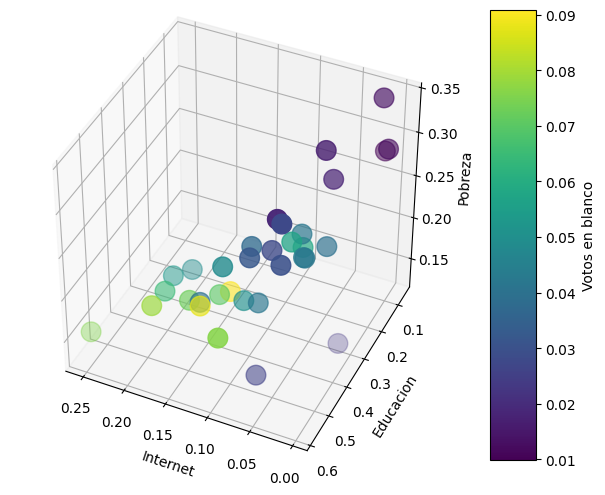

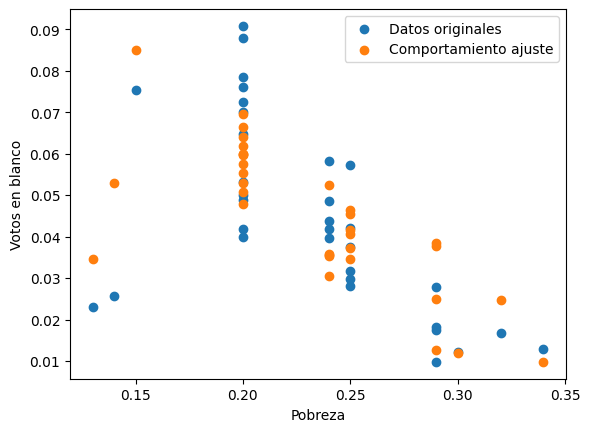

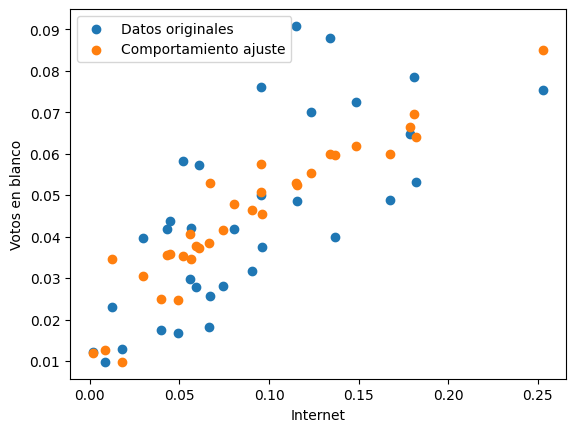

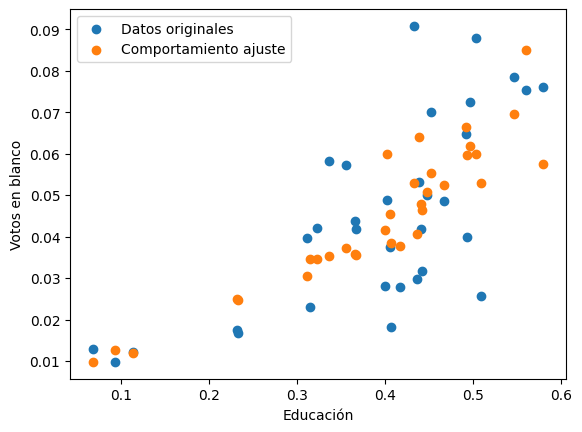

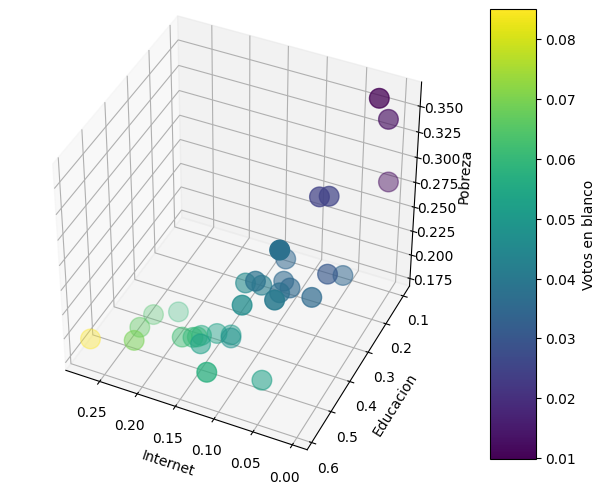

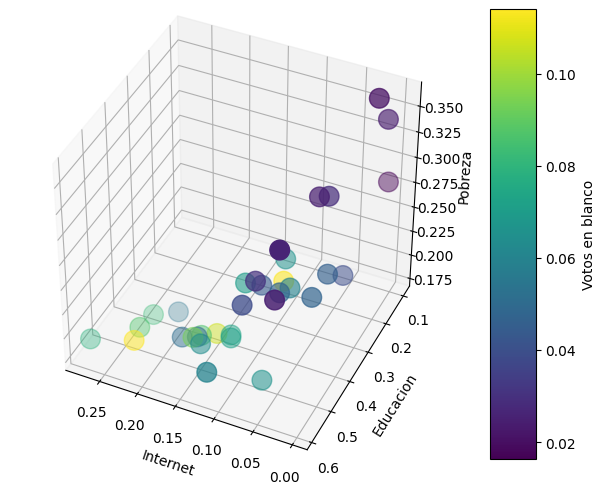

In [15]:
#Gráfica relación todos
fig=plt.figure()
ax = fig.add_subplot(111, projection ="3d")

p= ax.scatter(xs,ys,zs,c=col, s=200)
ax.set_xlabel("Internet")
ax.set_ylabel("Educacion")
ax.set_zlabel('Pobreza')
plt.tight_layout()
ax.set_box_aspect([1,1,1])


c=fig.colorbar(p, shrink=1, aspect=10,ax=ax)
c.set_label("Votos en blanco")
ax.view_init(40,115)

#Gráfica c/u
plt.figure()
plt.scatter(zs,col,label="Datos originales")
plt.scatter(zs,betas_x*xs+betas_y*ys+betas_z*zs+betas_inter, label="Comportamiento ajuste")
plt.xlabel("Pobreza")
plt.ylabel("Votos en blanco")
plt.legend()

plt.figure()
plt.scatter(xs,col,label="Datos originales")
plt.scatter(xs,betas_x*xs+betas_y*ys+betas_z*zs+betas_inter, label="Comportamiento ajuste")
plt.xlabel("Internet")
plt.ylabel("Votos en blanco")
plt.legend()

plt.figure()
plt.scatter(ys,col,label="Datos originales")
plt.scatter(ys,betas_x*xs+betas_y*ys+betas_z*zs+betas_inter, label="Comportamiento ajuste")
plt.xlabel("Educación")
plt.ylabel("Votos en blanco")
plt.legend()

zs_new=np.array(Estad_pobreza[llav_Estad_pobreza[4]])
ys_new=np.array(Estad_educacion_2020[llav_Estad_educacion[9]]/100)
xs_new=np.array(Estad_internet[llav_Estad_internet[3]])

for i in range(32):
    print("{}- prediccion: {:.3f} real {:.3f}".format(Estad_pobreza[llav_Estad_pobreza[0]][i],betas_x*xs_new[i]+betas_y*ys_new[i]+betas_z*zs_new[i]+betas_inter,data_2020[llav_data_2020[2]][i]/data_2020[llav_data_2020[1]][i]))


#Gráfica relación todos prediccion
fig=plt.figure()
ax = fig.add_subplot(111, projection ="3d")

p= ax.scatter(xs_new,ys_new,zs_new,c=betas_x*xs+betas_y*ys+betas_z*zs+betas_inter, s=200)
ax.set_xlabel("Internet")
ax.set_ylabel("Educacion")
ax.set_zlabel('Pobreza')
plt.tight_layout()
ax.set_box_aspect([1,1,1])

c=fig.colorbar(p, shrink=1, aspect=10,ax=ax)
c.set_label("Votos en blanco")
ax.view_init(40,115)

#Gráfica relación todos real
fig=plt.figure()
ax = fig.add_subplot(111, projection ="3d")

p= ax.scatter(xs_new,ys_new,zs_new,c=data_2020[llav_data_2020[2]]/data_2020[llav_data_2020[1]], s=200)
ax.set_xlabel("Internet")
ax.set_ylabel("Educacion")
ax.set_zlabel('Pobreza')
plt.tight_layout()
ax.set_box_aspect([1,1,1])

c=fig.colorbar(p, shrink=1, aspect=10,ax=ax)
c.set_label("Votos en blanco")
ax.view_init(40,115)